# Simple example of transfer learning and fine tuning of Vision Transformer for Cifar10 dataset

In [1]:
!pip install vit_keras

  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19582 sha256=52e97296ca766e5ac15c907e123391f2d7836e8cebccb953e16b7133c53c16cd
  Stored in directory: /root/.cache/pip/wheels/5f/55/ab/36a76989f7f88d9ca7b1f68da6d94252bb6a8d6ad4f18e04e9
Successfully built validators


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout, Activation, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.datasets import cifar10
from vit_keras import vit, utils
import tensorflow_addons as tfa
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import gc

In [3]:
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

**Load Cifar10 data**

In [4]:
(train_data, train_label), (test_data, test_label) = cifar10.load_data()
train_label = to_categorical(train_label)
test_label = to_categorical(test_label)
train_data = (train_data/255.).astype("float32")
test_data = (test_data/255.).astype("float32")

170508288/170498071 [==============================] - 2s 0us/step


In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_label, random_state=seed, shuffle=True)

**Makes data augmentation generator**

In [6]:
batch_size = 32
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

**Defines ViT model**

In [7]:
input_shape = (32, 32, 3) #Cifar10 image size
image_size = 256 #size after resizing image
num_classes = 10

def build_model():
    inputs = Input(shape=input_shape)
    x = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (image_size, image_size)))(inputs) #Resize image to  size 224x224
    base_model = vit.vit_b16(image_size=image_size, activation="sigmoid", pretrained=True,
                            include_top=False, pretrained_top=False)
    
    base_model.trainable = False #Set false for transfer learning
    x = base_model(x)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation=tfa.activations.gelu)(x)
    x = BatchNormalization()(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model_final = Model(inputs=inputs, outputs=outputs)
    return model_final

**Step1: Train only top layer (Transfer learning step)**

In [8]:
model = build_model()
model.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()
print("\n")
model.fit(train_generator,
          steps_per_epoch=200,
          epochs=2,
          validation_data=(X_valid, y_valid),
         )
gc.collect()

347512832/347502902 [==============================] - 2s 0us/step


/opt/conda/lib/python3.7/site-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 16, 16
  UserWarning,


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
lambda (Lambda)              (None, 256, 256, 3)       0         
_________________________________________________________________
vit-b16 (Functional)         (None, 768)               85844736  
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 768)               3072      
_________________________________________________________________
dense (Dense)                (None, 32)                24608     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128   

812

**Step2: Train entire layers again (Fine tuning step)**

In [9]:
#Set training callbacks
plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=1, verbose=1)
earlystopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1)

#Switch ViT layer to trainable for fine tuning
for layer in model.layers:
    layer.trainable = True
    
#Requires compile again to activate trainable=True
model.compile(optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()
print("\n")
history = model.fit(train_generator,
                    steps_per_epoch=200, #you can delete this parameter to achieve more accuracy, but takes much time.
                    epochs=5,
                    validation_data=(X_valid, y_valid),
                    callbacks=[plateau, earlystopping]
                   )
print("\nTest Accuracy: ", accuracy_score(np.argmax(test_label, axis=1), np.argmax(model.predict(test_data), axis=1)))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
lambda (Lambda)              (None, 256, 256, 3)       0         
_________________________________________________________________
vit-b16 (Functional)         (None, 768)               85844736  
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 768)               3072      
_________________________________________________________________
dense (Dense)                (None, 32)                24608     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128   

**Plot learning history**

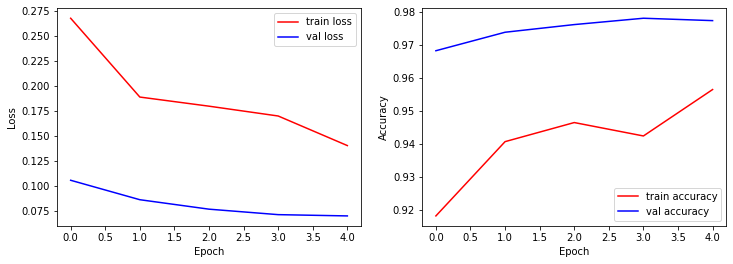

In [10]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
ax[0].plot(history.history["loss"], c="r", label="train loss")
ax[0].plot(history.history["val_loss"], c="b", label="val loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(history.history["accuracy"], c="r", label="train accuracy")
ax[1].plot(history.history["val_accuracy"], c="b", label="val accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()